In [1]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [2]:
%cd gdrive/MyDrive

/content/gdrive/MyDrive


In [12]:
# Libraries

import pandas as pd
import time
import numpy as np
import random
import os
from tqdm import tqdm
import itertools
import PIL

# Data Analysis
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

#TensorFlow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow import keras

# Sklearn
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Classes Tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, GlobalAveragePooling2D, Input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet_v2 import ResNet152V2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

%matplotlib inline

In [4]:
# Emplacement
path = '/content/gdrive/MyDrive/Projet Radio DST/data'

dirs = ["Normal/images/","COVID/images/","Lung_Opacity/images/","Viral Pneumonia/images/"]
dirsm = ["Normal/masks/","COVID/masks/","Lung_Opacity/masks/","Viral Pneumonia/masks/"]

id_dir = 6

# Classes de 0 à 3 dans la suite
classes = ("Normal","COVID ","Lung_Opacity","Viral Pneumonia") 
nbClasses = len(classes)

In [5]:
# Création des 4 listes de noms d'images

normal_imgs = [fn for fn in os.listdir(f'{path}/Normal/masked_images') if fn.endswith('.png')]
covid_imgs = [fn for fn in os.listdir(f'{path}/COVID/masked_images') if fn.endswith('.png')]
pneumonia_imgs = [fn for fn in os.listdir(f'{path}/Viral Pneumonia/masked_images') if fn.endswith('.png')]
lung_opacity_imgs = [fn for fn in os.listdir(f'{path}/Lung_Opacity/masked_images') if fn.endswith('.png')]

In [6]:
# Concaténation des emplacements de toutes les images dans une liste unique
liste_paths = []

for fn in normal_imgs :
    liste_paths.append(f'{path}/Normal/masked_images/' + fn)
for fn in covid_imgs :
    liste_paths.append(f'{path}/COVID/masked_images/' + fn)
for fn in pneumonia_imgs :
    liste_paths.append(f'{path}/Viral Pneumonia/masked_images/' + fn)
for fn in lung_opacity_imgs :
    liste_paths.append(f'{path}/Lung_Opacity/masked_images/' + fn)

# Découpage des noms de chaque emplacement et récupération de la classe (liste de listes)
liste_paths_classes = list(map(lambda x : [x, x.split('/')[id_dir]], liste_paths)) 

In [7]:
# Création Dataframe des emplacements et classes images BRUTES
df = pd.DataFrame(liste_paths_classes, columns = ['filepath', 'nameLabel'])

# Remplacement des classes sous forme littérale par index
df['label'] = df['nameLabel'].replace(df.nameLabel.unique(), [*range(len(df.nameLabel.unique()))])
df['label'] = df['label'].astype(str)

# Mélange du dataframe
df = df.sample(frac = 1, random_state = 42)
df = df.reset_index(drop=True)

# Nettoyage variables inutiles
del liste_paths

ech_size = 2000

df = df[0:ech_size]
print(df['nameLabel'].value_counts())
df.head()

Lung_Opacity       500
Normal             500
Viral Pneumonia    500
COVID              500
Name: nameLabel, dtype: int64


,filepath,nameLabel,label
0,/content/gdrive/MyDrive/Projet Radio DST/data/...,Lung_Opacity,3
1,/content/gdrive/MyDrive/Projet Radio DST/data/...,Normal,0
2,/content/gdrive/MyDrive/Projet Radio DST/data/...,Viral Pneumonia,2
3,/content/gdrive/MyDrive/Projet Radio DST/data/...,COVID,1
4,/content/gdrive/MyDrive/Projet Radio DST/data/...,Viral Pneumonia,2


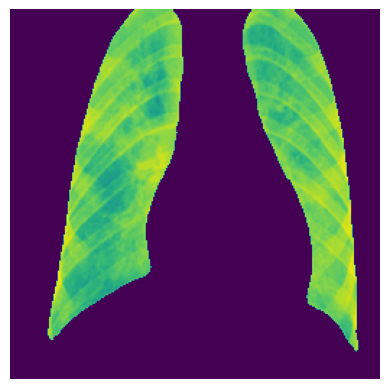

In [8]:
#Charger Exemple Image
filepath = df.filepath[9]

im = tf.io.read_file(filepath)
im = tf.image.decode_jpeg(im, channels = 1)
plt.imshow(im)
plt.axis('off');

In [9]:
size = (224, 224)
ratio_val = 0.2 
batch_generator = 32

# Séparation dataframe en ensemble entraiement et validation
train_total, test = train_test_split(df, test_size = ratio_val, shuffle = False)
train, valid = train_test_split(train_total, test_size = 0.1)

# Création des itérateurs qui chargeront des lots d'images
datagen = ImageDataGenerator( )
test_datagen = ImageDataGenerator( )

print(f"Number of rows in TRAIN total set: {len(train_total)}")
print(f" - Number of rows in train_set: {len(train)}")
print(f" - Number of rows in valid_set: {len(valid)}")

train_generator = datagen.flow_from_dataframe(dataframe = train,
                                              x_col="filepath",
                                              y_col="label",
                                              class_mode = "sparse",
                                              target_size = size,
                                              batch_size = batch_generator)

valid_generator = datagen.flow_from_dataframe(dataframe = valid,
                                              x_col="filepath",
                                              y_col="label",
                                              class_mode = "sparse",
                                              target_size = size,
                                              batch_size = batch_generator)


Number of rows in TRAIN total set: 1600
 - Number of rows in train_set: 1440
 - Number of rows in valid_set: 160
Found 1440 validated image filenames belonging to 4 classes.
Found 160 validated image filenames belonging to 4 classes.


In [10]:
print(f"Number of rows in TEST set: {len(test)}")

test_generator = test_datagen.flow_from_dataframe(dataframe = test,
                                                x_col="filepath",
                                                y_col="label",
                                                class_mode = "sparse",
                                                target_size = size,
                                                batch_size = batch_generator,
                                                shuffle = False) 

X_test = []

for filepath in tqdm(test['filepath']) :
    im = tf.io.read_file(filepath)
    im = tf.image.decode_jpeg(im, channels = 1)
    im = tf.image.resize (im, size)
    X_test.append([im])
    
X_test = tf.concat(X_test, axis = 0)

Number of rows in TEST set: 400
Found 400 validated image filenames belonging to 4 classes.


100%|██████████| 400/400 [03:06<00:00,  2.14it/s]


## ResNet Model Architecture

In [13]:
#Chargement et freeze modèle de base
resnet152_base = ResNet152V2(weights = 'imagenet', include_top = False)

for layer in resnet152_base.layers :
    layer.trainable = False

resnet152_base.summary()

234545216/234545216 [==============================] - 13s 0us/step
Model: "resnet152v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_1[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                    

In [14]:
def resnet152() :
    model = Sequential()
    
    model.add(resnet152_base)
    
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units = 1024, activation = 'relu'))
    model.add(Dropout(rate = 0.2))
    model.add(Dense(units = 512, activation = 'relu'))
    model.add(Dropout(rate = 0.2))
    model.add(Dense(units = 4, activation = 'softmax'))
    
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    #hp_learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    hp_learning_rate = 0.001
    
    model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                  optimizer = tf.keras.optimizers.Adam(learning_rate = hp_learning_rate), 
                  metrics = ["accuracy"])
    
    return model

In [15]:
model = resnet152()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet152v2 (Functional)    (None, None, None, 2048)  58331648  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                        

In [16]:
from keras.utils.vis_utils import plot_model

plot_model(resnet152_base, to_file = 'resnet152_base_plot.png', show_shapes = True, show_layer_names = True)

Output hidden; open in https://colab.research.google.com to view.

In [17]:
#Callbacks

#define checkpoint
checkpoint = ModelCheckpoint('model.h5', 
                             monitor = 'val_accuracy',
                             save_best_only = True,
                             mode = 'auto',
                             verbose = 1)

#early stopping
#EarlyStopping: a regularization technique, meaning that the model will stop training if it doesn’t see any improvement in 
#val_accuracy in patience = 5 i.e. 5 epochs.'
earlystop = EarlyStopping(monitor = 'val_accuracy',
                          patience = 5,
                          mode = 'auto',
                          verbose = 1)

#reduce learning rate
#ReduceLROnPlateau to reduce learning rate when val_accuracy has stopped improving.
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', 
                              factor = 0.3, 
                              patience = 2, 
                              min_delta = 0.001,
                              mode = 'auto',
                              verbose = 1)

## Entrainement Modèle

In [18]:
# Entrainement du modèle
train_size = train_generator.samples
valid_size = valid_generator.samples

batch_model = 32
epochs = 30

history = model.fit(train_generator,
                    epochs = epochs,
                    steps_per_epoch = train_size // batch_model,
                    validation_data = valid_generator,
                    validation_steps = valid_size // batch_model,
                    verbose = 1,
                    callbacks = [checkpoint, earlystop, reduce_lr])

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


45/45 [==============================] - ETA: 0s - loss: 86.1722 - accuracy: 0.2924 
Epoch 1: val_accuracy improved from -inf to 0.56250, saving model to model.h5
45/45 [==============================] - 685s 15s/step - loss: 86.1722 - accuracy: 0.2924 - val_loss: 1.6709 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 2/30
45/45 [==============================] - ETA: 0s - loss: 2.2460 - accuracy: 0.3993
Epoch 2: val_accuracy did not improve from 0.56250
45/45 [==============================] - 12s 267ms/step - loss: 2.2460 - accuracy: 0.3993 - val_loss: 1.1368 - val_accuracy: 0.5312 - lr: 0.0010
Epoch 3/30
45/45 [==============================] - ETA: 0s - loss: 1.2731 - accuracy: 0.3521
Epoch 3: val_accuracy did not improve from 0.56250

Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
45/45 [==============================] - 14s 309ms/step - loss: 1.2731 - accuracy: 0.3521 - val_loss: 1.2264 - val_accuracy: 0.3938 - lr: 0.0010
Epoch 4/30
45/45 [=================

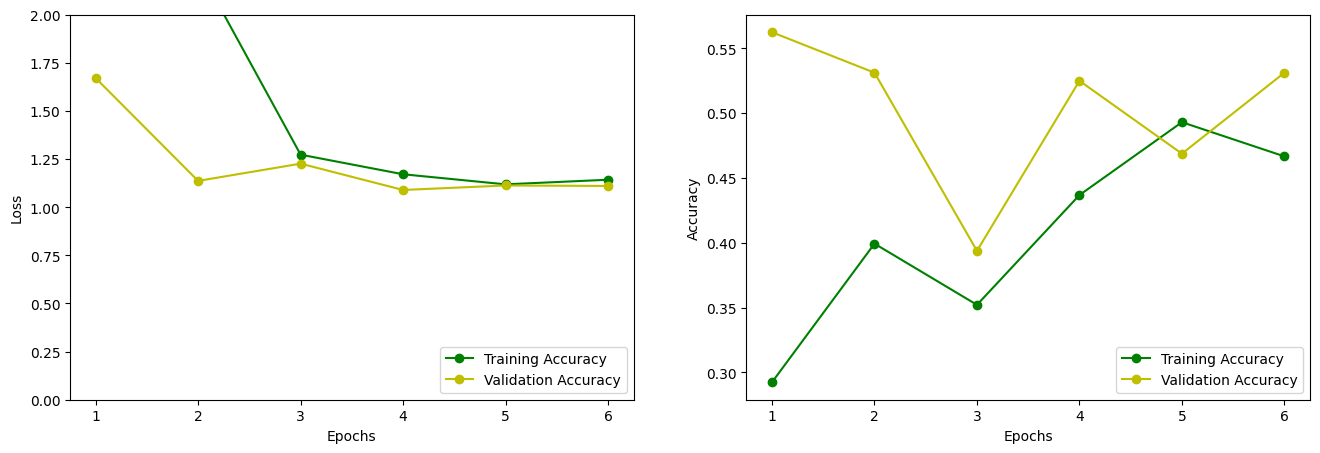

In [19]:
# Courbes de perte et d'accuracy
plt.figure(figsize = (16,5))

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

plt.subplot(121)
plt.plot(epochs, train_loss, 'g-o', label = 'Training Accuracy')
plt.plot(epochs, val_loss, 'y-o',  label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,2)

plt.subplot(122)
plt.plot(epochs, train_acc, 'g-o', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'y-o',  label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show();

## Model Performance

In [20]:
print('TRAIN accuracy & loss:', model.evaluate(train_generator))
print('\n')
print('TEST accuracy & loss:', model.evaluate(test_generator))

45/45 [==============================] - 10s 230ms/step - loss: 1.0753 - accuracy: 0.5549
TRAIN accuracy & loss: [1.0753099918365479, 0.5548611283302307]


13/13 [==============================] - 4s 300ms/step - loss: 1.0981 - accuracy: 0.5275
TEST accuracy & loss: [1.0981487035751343, 0.5274999737739563]


In [ ]:
#### Predictions 

In [21]:
y_test = test_generator.classes
y_test = pd.DataFrame(y_test).astype(int)

y_pred = np.argmax(model.predict(test_generator), axis = 1)

13/13 [==============================] - 6s 221ms/step


In [ ]:
#### Confusion Matrix

In [22]:
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion Matrix',
                          cmap = plt.cm.Blues):
    
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    plt.grid(False)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 fontsize = 12,
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

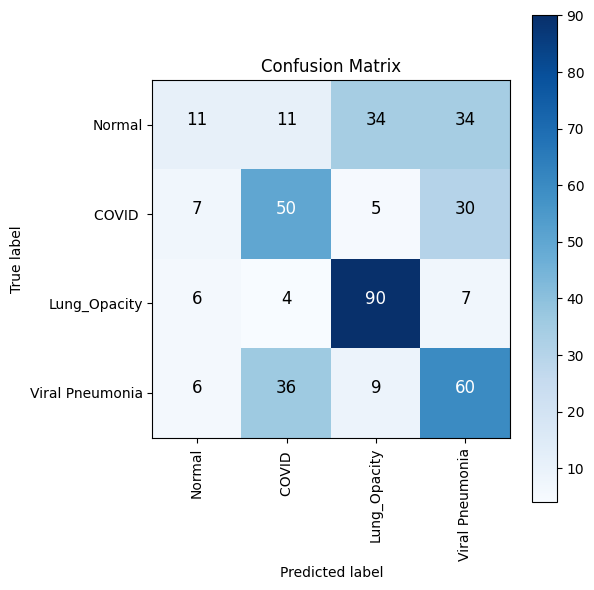

[[11 11 34 34]
 [ 7 50  5 30]
 [ 6  4 90  7]
 [ 6 36  9 60]]


In [23]:
cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm, classes, normalize = False)
print(cm)

In [ ]:
#### Classification Report

In [24]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.37      0.12      0.18        90
           1       0.50      0.54      0.52        92
           2       0.65      0.84      0.73       107
           3       0.46      0.54      0.50       111

    accuracy                           0.53       400
   macro avg       0.49      0.51      0.48       400
weighted avg       0.50      0.53      0.49       400



## Predictions on Test Images 

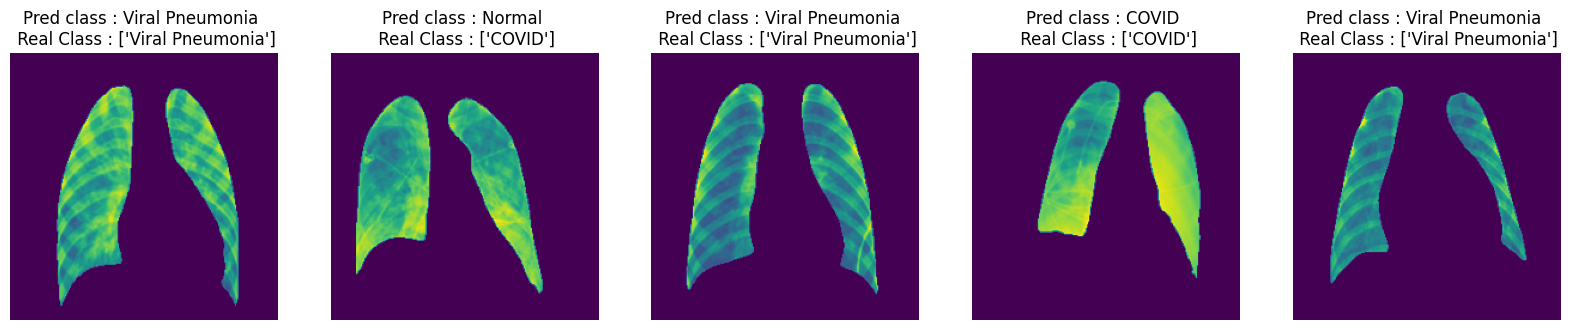

In [25]:
#Prédiction du modèle

indices_random = tf.random.uniform([5], 0, len(test['filepath']), dtype = tf.int32)

plt.figure(figsize = (20,10))

for i, idx in enumerate(indices_random) :
    plt.subplot(1,5,i+1)
    plt.imshow(tf.cast(X_test[idx], tf.int32))
    plt.axis('off')
    plt.title('Pred class : {} \n Real Class : {}'.format(df.nameLabel.unique()[y_pred[idx]], df.nameLabel.unique()[y_test.values[idx]]))

In [26]:
model.save_weights("model_resnet152_callbacks_2000mkd.h5")

In [ ]:
model.load_weights("C:/Users/utilisateur/COVID19 - Projet/model_resnet152_2000mkd.h5")